# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

#### Import libraries

In [179]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from pandas.io.json import json_normalize
from dython.nominal import associations

# Visualización de missing values
import missingno as msno

import klib
%matplotlib inline

#Configuración de  pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Tema JupyterNotebook
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


import warnings
warnings.filterwarnings('ignore')

##### Read dataset

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [16]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# The channels column is regulated by dividing each of the data
#portfolio = portfolio.explode('channels')
#portfolio.tail(5)

In [5]:
portfolio[portfolio['id'] == '2906b810c7d4411798c6938adc9daaa5']

,reward,channels,difficulty,duration,offer_type,id
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
profile[profile['id'] == '4869681400d94bfabe9d3923cc251b26']

,gender,age,id,became_member_on,income
12735,M,61,4869681400d94bfabe9d3923cc251b26,20151205,31000.0


In [7]:
# Display dataset profile
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [57]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### EDA (Exploratory Data Analysis)

In [22]:
print(f"Dataset portfolio have {portfolio.shape[0]} rows and {portfolio.shape[1]} columns")
print(f"Dataset portfolio have {profile.shape[0]} rows and {profile.shape[1]} columns")
print(f"Dataset portfolio have {transcript.shape[0]} rows and {transcript.shape[1]} columns")

Dataset portfolio have 33 rows and 6 columns
Dataset portfolio have 17000 rows and 5 columns
Dataset portfolio have 306534 rows and 4 columns


Once the amount of data is taken into account, we will check how many missing values there are in each dataset.

##### Detect missing values for each dataset

<br>

##### Portfolio

In [16]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

As can be seen, this dataset does not have any null value.

##### Profile

In [25]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [33]:
# Ratio of missing values to the actual dataset
print(f"There is a {round(( profile.isnull().sum()[0] / profile.shape[0]) * 100,2)}% of missing values in the dataset Profile ")

There is a 12.79% of missing values in the dataset Profile 


##### Transcript

In [23]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

Like the ``portfolio`` dataset, ``transcript`` has no missing values. 

<br> 

Let's explore each of the different events that can be seen within the transcript dataset.

In [63]:

transcript.groupby('event').count()

,id,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


The following image shows the funnel of sales conversions of the marketing campaign. In the upper part are the ``offers received`` with a total of **76277**, in the middle part the ``offers viewed`` with **57725**, representing ``76%`` of the total ``offers received``.

<br>

Finally, the conversion of ``offers completed``  was **33579** which is ``44%`` of the offers sent.

<br> 

<img src="images/funnel.jpg"    
     style="max-width: 50%">

Now the event column of the ``transcript`` table will be normalized to know what type of event the ``offer_id`` refers to and thus interpret the data in depth. For this purpose, two functions were designed to meet this objective.


In [8]:
# Normalize column
def drop_missing_values(df, column, target_key):
    """
    
    drop_missing_values: Gets the specified event (target) and converts it into a dataframe.
    
    Parameters:
        df: Transcript dataset
        column: The name of the column where the json objects are located.
        target_key: Name of the key to extract the information
        
    Return:
        df: Normalized dataframe with the specified key, as column, and their respective values.
    """
    df = df[column].apply(pd.Series)
    
    df_final = df[[target_key]]
    df_final = df_final.dropna()
    df_final = df_final.reset_index()
    
    return df_final

def merge_dataset(general_dataset, column, target_key):
    """
    merge_dataset: merge transcript dataset with the values of the specified key (target_key) 
    
    Parameters:
        general_dataset: transcript dataset.
        column: The name of the column where the json objects are located.
        target_key: Name of the key to extract the information
        
    Return:
        df: Normalized dataframe with the specified key, as column, and their respective values.
    
    """
    data_normalize = drop_missing_values(general_dataset, column, target_key)
    general_dataset =  general_dataset.reset_index()
    
    final_data = pd.merge(general_dataset, data_normalize.reset_index(), on='index', how="inner")
    final_data.drop(['level_0', 'value'], axis=1, inplace=True)   
    
    return final_data

In [9]:
# Dataset del evento amount
transaction = merge_dataset(transcript, "value", "amount")
transaction.head(5)

,index,person,event,time,amount
0,12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
2,12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
4,12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [10]:
# Dataset del evento ofertas recibidas y vistas
offers = merge_dataset(transcript, "value", "offer id")
offers.head(5)

,index,person,event,time,offer id
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [75]:
# Event dataset of completed offers
offer_completed = merge_dataset(transcript, "value", "offer_id")
offer_completed.head(5)

,index,person,event,time,offer_id
0,12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5
1,12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4
2,12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd
4,12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [82]:
# Perform a merge to obtain a dataset of the completed columns along with the profile and portfolio table information.
final_dataset = pd.merge(profile, offer_completed, how="inner", left_on= "id",  right_on="person").\
            merge(portfolio, how="inner", left_on= "offer_id",  right_on="id")

columns_df_completed = ['id_x', 'index', 'id_y', 'offer_id', 'became_member_on', 'event']

# Delete columns
final_dataset.drop(columns_df_completed, axis=1, inplace=True)
final_dataset.head(5)

,gender,age,income,person,time,reward,channels,difficulty,duration,offer_type
0,None,118,NaN,68be06ca386d4c31939f3a4f0e3dd783,552,2,"[web, email, mobile, social]",10,10,discount
1,M,68,70000.0,e2127556f4f64592b11af22de27a7932,522,2,"[web, email, mobile, social]",10,10,discount
2,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,600,2,"[web, email, mobile, social]",10,10,discount
3,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,456,2,"[web, email, mobile, social]",10,10,discount
4,F,62,71000.0,31dda685af34476cad5bc968bdb01c53,258,2,"[web, email, mobile, social]",10,10,discount


In [83]:
# Check number rows and columns
final_dataset.shape

(33579, 10)

In [84]:
# Check missing values
final_dataset.isnull().sum()

gender        1135
age              0
income        1135
person           0
time             0
reward           0
channels         0
difficulty       0
duration         0
offer_type       0
dtype: int64

Now let's look at the missing values graphically. 

GridSpec(6, 6)

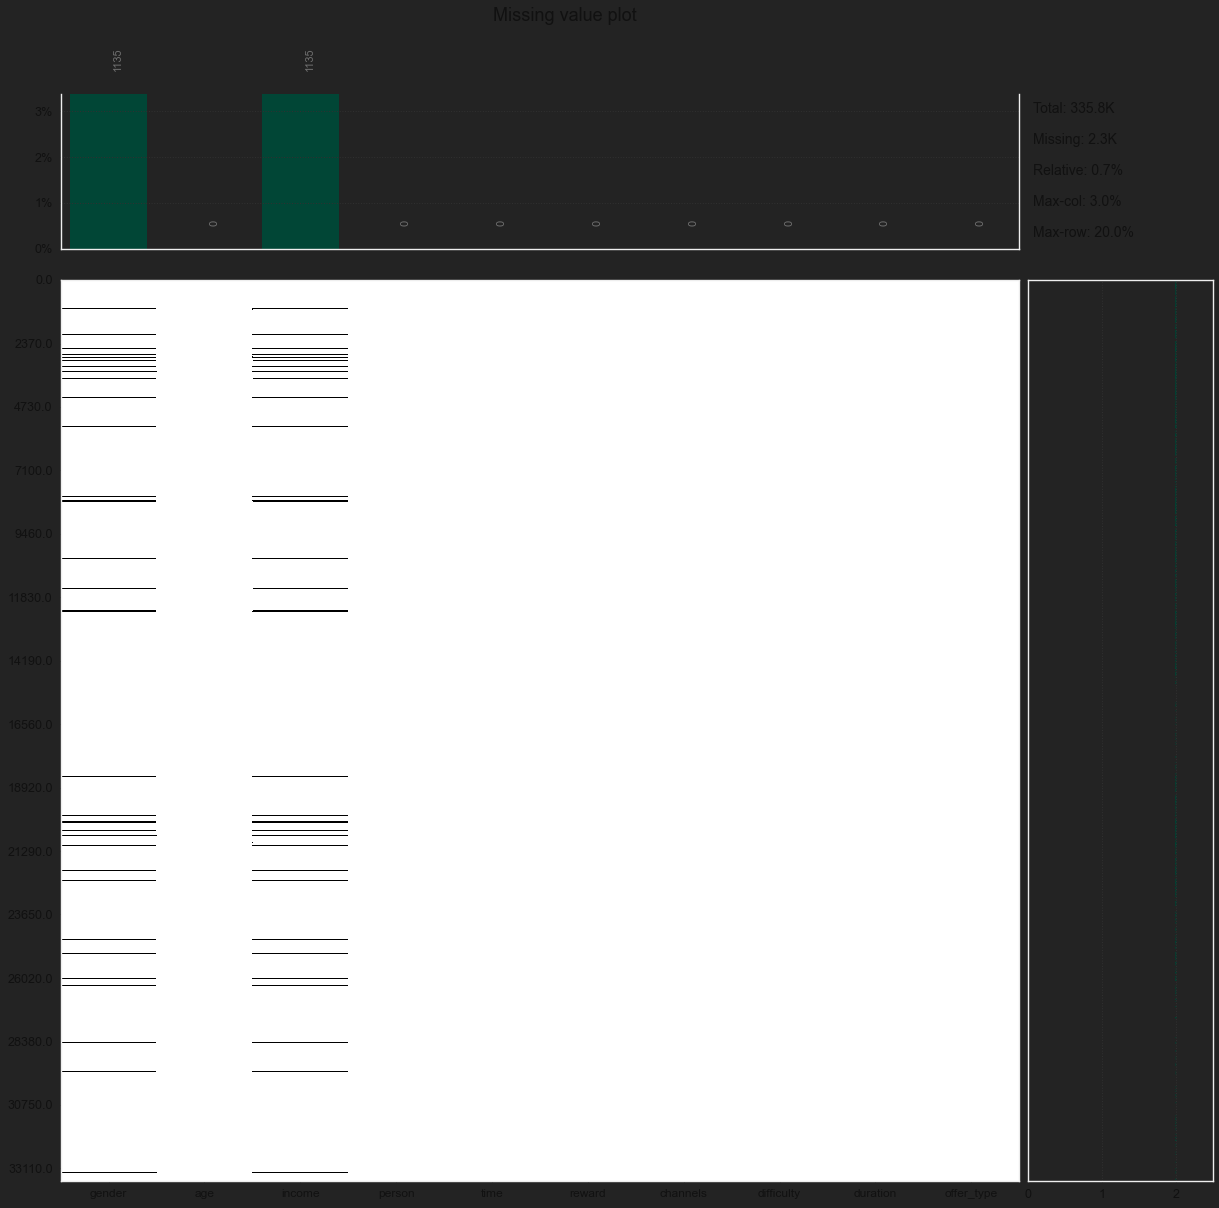

In [85]:
klib.missingval_plot(final_dataset)

A pattern can be observed in the missing values for the **gender** and **income** columns. The procedure to be performed is to remove each of these null values. 

In [86]:
# Delete missing values
final_dataset.dropna(inplace=True)

In [87]:
# Save dataset
final_dataset.to_csv('final_dataset.csv')

With the first data cleaning we performed in the previous steps, we will now generate a report to understand the nature of each of the data. 

In [88]:
# Portfolio report
report = ProfileReport(final_dataset, title='Report for final dataset V1.0', dataset={'creator':'Carlos Barros'},
                        html={'style':{'full_width':True}})

report.to_file("final dataset.html")

In [89]:
report

In [130]:
# Change data type float to int 
for y in final_dataset.columns:
    if(final_dataset[y].dtype == np.float64):
        final_dataset[y] = final_dataset[y].astype(int)

final_dataset.dtypes

gender        object
age            int64
income         int32
person        object
time           int64
reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
dtype: object

#### Statistics and Visualization

In [94]:
final_dataset.describe()

,age,income,time,reward,difficulty,duration
count,32444.000000,32444.000000,32444.000000,32444.000000,32444.00000,32444.000000
mean,55.826624,69430.803847,399.615645,4.948249,9.31411,7.318734
std,16.809418,21604.250324,192.577529,2.905376,4.20840,1.771882
min,18.000000,30000.000000,0.000000,2.000000,5.00000,5.000000
25%,45.000000,53000.000000,234.000000,2.000000,5.00000,7.000000
50%,57.000000,69000.000000,432.000000,5.000000,10.00000,7.000000
75%,67.000000,85000.000000,558.000000,5.000000,10.00000,10.000000
max,101.000000,120000.000000,714.000000,10.000000,20.00000,10.000000


It can be observed that ``age`` presents an atypical value because its maximum value is **101** years. The following box-and-whisker plot shows this better. 

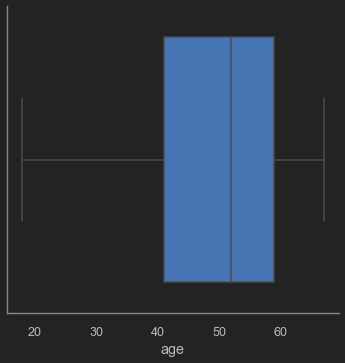

In [182]:
sns.catplot(x='age', data=final_dataset, kind='box')
plt.show()

In order to solve the above, we will work as a limit up to the ``third percentile``, that is, up to the age of **67** years. 

In [136]:
final_dataset = final_dataset[final_dataset['age'] <= 67]

In [168]:
numeric_columns = final_dataset.select_dtypes([np.int32, np.int64])
numeric_columns = numeric_columns[['age', 'time', 'income']]

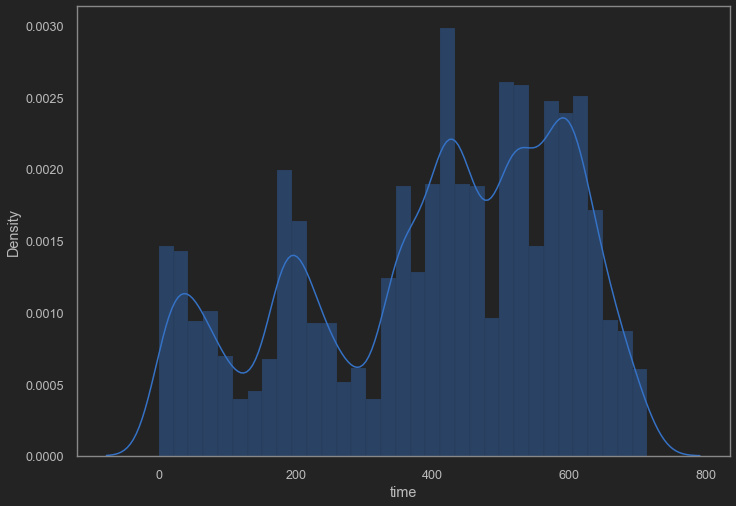

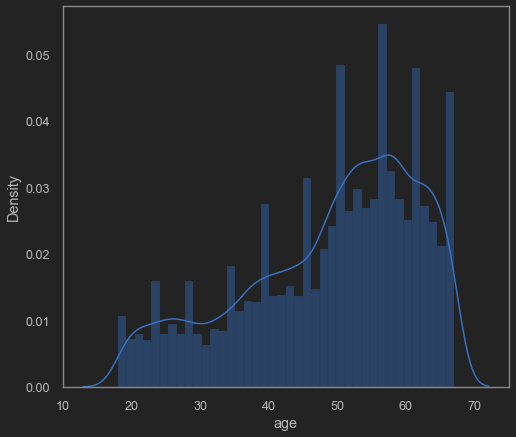

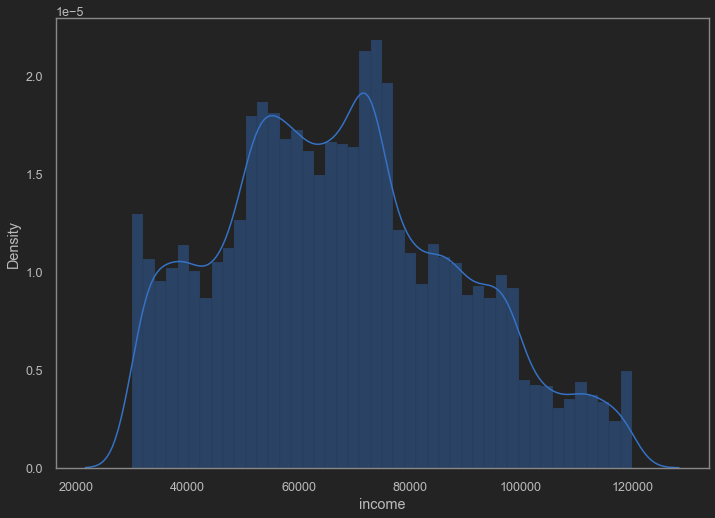

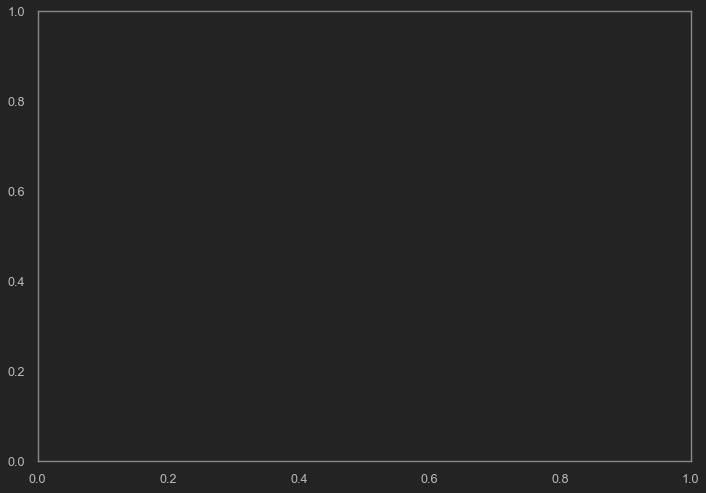

In [180]:
for i, col in enumerate(numeric_columns.columns):
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)

    plt.figure(i)
    sns.distplot(numeric_columns[col])

Text(0.5, 0.98, 'Frecuency of obervation by -Ubicación-')

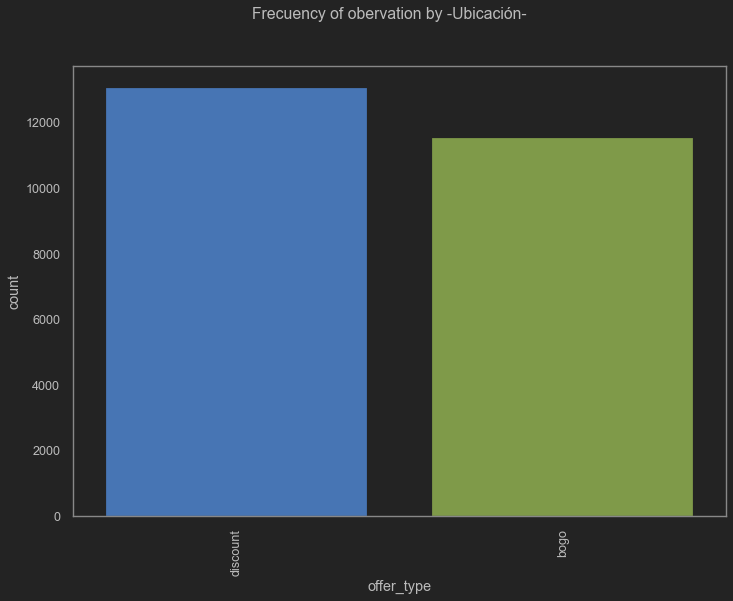

In [185]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
offer_type = sns.countplot(x='offer_type', data=final_dataset)
offer_type.set_xticklabels(offer_type.get_xticklabels(), rotation=90)
plt.suptitle('Frecuency of offer type')

Text(0.5, 0.98, 'Frecuency of genres')

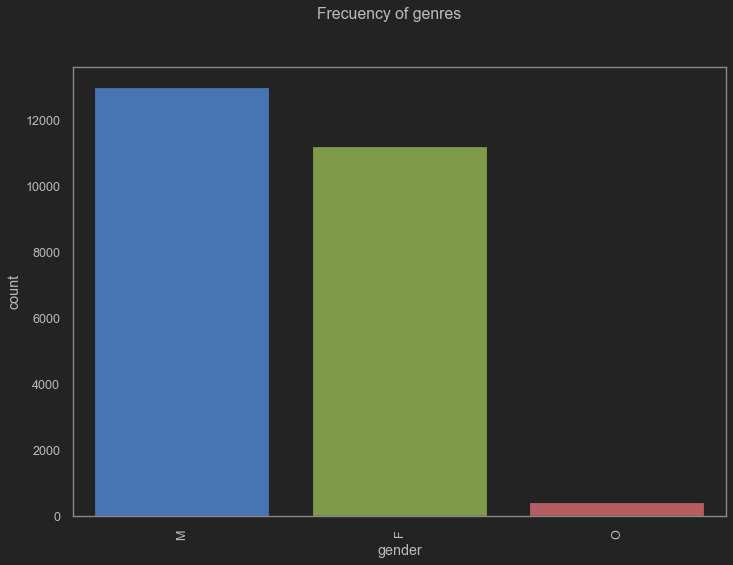

In [186]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
offer_type = sns.countplot(x='gender', data=final_dataset)
offer_type.set_xticklabels(offer_type.get_xticklabels(), rotation=90)
plt.suptitle('Frecuency of genres')

In [213]:
number_female = final_dataset.groupby('gender').count().iloc[0][0]
number_masculine = final_dataset.groupby('gender').count().iloc[1][0]
number_others = final_dataset.groupby('gender').count().iloc[2][0]

In [215]:
print(f'Female represent the {round(( number_female / final_dataset.shape[0])* 100, 2)} % over total population')
print(f'Male represent the {round(( number_masculine / final_dataset.shape[0])* 100, 2)} % over total population')
print(f'Others represent the {round(( number_others / final_dataset.shape[0])* 100, 2)} % over total population')

Female represent the 45.53 % over total population
Male represent the 52.85 % over total population
Others represent the 1.62 % over total population
